In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

## Load data

In [60]:
# Load data clinical data
df_clinical = pd.read_csv('_data/clinical.csv').set_index('pnr')
df_clinical["start"] = pd.to_datetime(df_clinical["start"]) # No error raise on date format

# Load inpatients
df_inpatient = pd.read_csv('_data/inpatient.csv')
df_inpatient["indatum"] = pd.to_datetime(df_inpatient["indatum"]) # No error raise on date format
df_inpatient["utdatum"] = pd.to_datetime(df_inpatient["utdatum"]) # No error raise on date format
df_inpatient = df_inpatient.set_index(['pnr'])


# Load outpatients
df_outpatient = pd.read_csv('_data/outpatient.csv')
df_outpatient["indatum"] = pd.to_datetime(df_outpatient["indatum"]) # No error raise on date format
df_outpatient = df_outpatient.set_index(['pnr'])


# Extract the number of visits from registry data

Here we assumed that no visits in the registry data means that the patient did not have a visit. Inpatient register started in 1997 and outpatient register in 2001. Taking only 5 years of historic for patients enable to be sure that a patient that started his or her treatment in 2010 could have been observed the past 5 years.

In [61]:
def get_5y_number_event(df_study, df_registry):
    """
    Get the number of visits from registry data (df_registry) for patients available in the study data (df_study)

    Args:
        df_study (pd.DataFrame): study data
        df_registry (pd.DataFrame): registry data

    Returns:
        pd. Series : number of visits from the registry for patients of interest
    """
    df_join = df_study.join(df_registry)
    # keep only the visits that are five years or less before the treatment start
    df_before = df_join[df_join['indatum'].between(df_join['start'] - pd.Timedelta(5*365.25, 'D'), df_join['start'])]
    return df_before.groupby('pnr').count()['HDIA']

In [62]:
# Get all inpatient visits for studied patients
df_clinical['nb_any_inpatient_visit']= get_5y_number_event(df_clinical, df_inpatient)
df_clinical['nb_any_inpatient_visit']= df_clinical['nb_any_inpatient_visit'].fillna(0)

In [63]:
tuple_diag_ok = ('I200', 'I21', 'I22', 'I23', 'I24')
col_diag = ['HDIA', 'DIA01', 'DIA02', 'DIA03', 'DIA04', 'DIA05', 'DIA06']

# Get inpatients visits with selected diag
df_in_bool = df_inpatient['HDIA']!=df_inpatient['HDIA'] # Initialise a bool DataFrame full of False are there are no nan
for col in col_diag:  
    df_in_bool = df_in_bool | df_inpatient[col].str.startswith(tuple_diag_ok)
df_clinical['nb_i_inpatient_visit']= get_5y_number_event(df_clinical, df_inpatient[df_in_bool])
df_clinical['nb_i_inpatient_visit']= df_clinical['nb_i_inpatient_visit'].fillna(0)

# Get outpatients visits with selected diag
df_out_bool = df_outpatient['HDIA']!=df_outpatient['HDIA']
for col in col_diag:  
    df_out_bool = df_out_bool | df_outpatient[col].str.startswith(tuple_diag_ok)
df_clinical['nb_i_outpatient_visit']= get_5y_number_event(df_clinical, df_outpatient[df_out_bool])
df_clinical['nb_i_outpatient_visit']= df_clinical['nb_i_outpatient_visit'].fillna(0)

# Sum both in and out visits with selected diag
df_clinical['nb_i_visit']= df_clinical['nb_i_outpatient_visit'] + df_clinical['nb_i_inpatient_visit']

# Analysis

First I compare the distributions

Treatments: A (58%), B (42%)


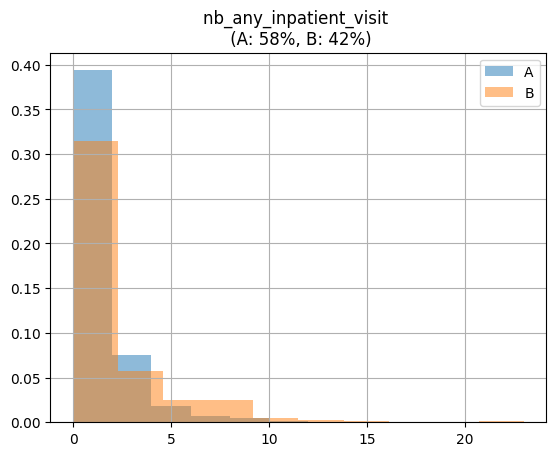

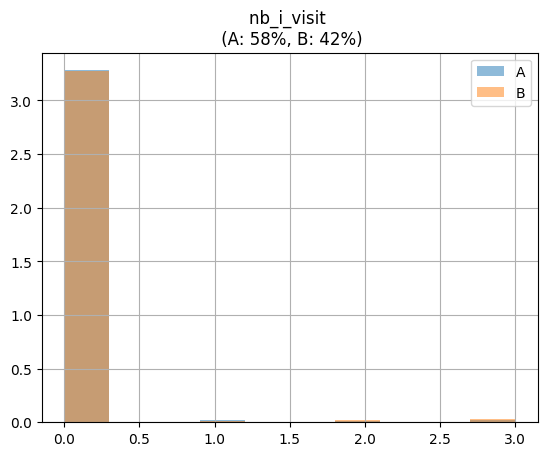

In [64]:
# Drug repartition
percent_A = round(len(df_clinical[df_clinical['drug']=="A"])/len(df_clinical)*100)
percent_B = round(len(df_clinical[df_clinical['drug']=="B"])/len(df_clinical)*100)
print(f"Treatments: A ({percent_A}%), B ({percent_B}%)")

for col_baseline in ['nb_any_inpatient_visit', 'nb_i_visit']:
    for drug, color in zip(["A", "B"], ["blue", "orange"]):
        df_plot = df_clinical[df_clinical['drug']==drug]
        df_plot[col_baseline].hist(density = True, alpha = 0.5,
                                   label = f"{drug}")
    plt.title(f"{col_baseline} \n (A: {percent_A}%, B: {percent_B}%)")
    plt.legend()
    plt.show()

Then I used a Mann Whitney U test to compare the distribution given the treatments as they are two independent groups with ordinal responses. 

In [65]:
for col in ['nb_any_inpatient_visit', 'nb_i_visit']:
    u, p_value = mannwhitneyu(df_clinical[df_clinical['drug']=='A'][col],
                       df_clinical[df_clinical['drug']=='B'][col])
    u = u/(len(df_clinical[df_clinical['drug']=='A'][col])*len(df_clinical[df_clinical['drug']=='A'][col]))
    print(col, round(u, 2), round(min(1, 3*p_value), 3) )

nb_any_inpatient_visit 0.27 0.0
nb_i_visit 0.36 1


# Save data

I save the data to use it for the assignment 3.

In [66]:
df_clinical.to_csv('_data/clinical_and_registry.csv')

# Conclusion
Patients treated with A have less inpatients visits of all types than patients treated with B. It could be interesting to understand if they are of a particular type. 